# Analyzing HIV Drug Resistance

We consider the dataset data set publicly available from the Stanford HIV Drug Resistance Database (https://hivdb.stanford.edu/pages/published_analysis/genophenoPNAS2006/)

In [2]:
import pandas as pd
import numpy as np

In [2]:
X = pd.read_csv("X.csv", index_col=0)
column_names = X.columns
X.head()

,P4.A,P12.A,P13.A,P16.A,P20.A,P22.A,P28.A,P37.A,P51.A,P54.A,...,P16.Z,P18.Z,P19.Z,P34.Z,P37.Z,P61.Z,P72.Z,P79.Z,P83.Z,P92.Z
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
Y = pd.read_csv("Y.csv", index_col=0)
Y.head()

,APV,ATV,IDV,LPV,NFV,RTV,SQV
1,2.3,NaN,32.7,NaN,23.4,51.6,37.8
2,76.0,NaN,131.0,200.0,50.0,200.0,156.0
3,2.8,NaN,12.0,NaN,100.0,41.0,145.6
4,6.5,9.2,2.1,5.3,5.0,36.0,13.0
5,8.3,NaN,100.0,NaN,161.1,170.2,100.0


In [5]:
Y.isna().sum(axis=0)

APV     79
ATV    518
IDV     21
LPV    331
NFV      4
RTV     53
SQV     22
dtype: int64

# Exercise 1

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions
import os
os.environ['CMDSTAN'] = '/Users/Cheesecake/.cmdstanr/cmdstan-2.28.1'
from cmdstanpy import CmdStanModel, set_cmdstan_path
import arviz as az

In [103]:
horseshoe_code = """
    data {
        int<lower=0> d;
        int<lower=0> tau;
    }
    
    parameters {
        vector[d] x;
        vector[d] lambda;
    }
    
    transformed parameters {
        vector[d] sigma;
        for (j in 1:d) {
            sigma[j] = tau^2 * lambda[j]^2;
        }
    }
    
    model {
        for (j in 1:d) {
            x[j] ~ normal(0.0, sigma[j]);
            lambda[j] ~ cauchy(0.0, 1.0);
        }
    }
"""

d = 1000
tau = 1

stan_file = "./horseshoe.stan"

with open(stan_file, "w") as f:
    print(horseshoe_code, file=f)
    
    
stan_model = CmdStanModel(stan_file=stan_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/Cheesecake/Documents/GitHub/BAY-STATS-Project-Anfossy-Bahtaoui-Pasupathipillai/Interactive/horseshoe
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/Cheesecake/Documents/GitHub/BAY-STATS-Project-Anfossy-Bahtaoui-Pasupathipillai/Interactive/horseshoe


In [104]:
horseshoe_data = {
    "d": 1000,
    "tau": 1,
}

stan_fit = stan_model.sample(data=horseshoe_data, chains=4, parallel_chains=4, 
                             iter_warmup=100, iter_sampling=500)

cmdstanpy_horseshoe_data1 = az.from_cmdstanpy(stan_fit)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2


In [105]:
np.sum(cmdstanpy_horseshoe_data1.sample_stats.diverging)

<xarray.DataArray 'diverging' ()>
array(1346)

In [84]:
horseshoe_data = {
    "d": 1000,
    "tau": 10,
}

stan_fit = stan_model.sample(data=horseshoe_data, chains=4, parallel_chains=4, 
                             iter_warmup=100, iter_sampling=500)

cmdstanpy_horseshoe_data10 = az.from_cmdstanpy(stan_fit)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4


In [92]:
finnish_horseshoe_code = """
    data {
        int<lower=0> d;
        real<lower=0> tau;
    }
    
    parameters {
        vector[d] x;
        vector[d] lambda;
        real c;
    }
    
    transformed parameters {
        vector[d] sigma;
        for (j in 1:d) {
            sigma[j] = (lambda[j]^2 * c^2) / (tau ^2 * lambda[j]^2 + c^2);
        }
    }
    
    model {
        for (j in 1:d) {
            x[j] ~ normal(0.0, sigma[j]);
            lambda[j] ~ cauchy(0.0, 1.0);
            c ~ inv_gamma(1.5, 1.5);
        }
    }
"""

d = 1000

stan_file = "./finnish_horseshoe.stan"

with open(stan_file, "w") as f:
    print(finnish_horseshoe_code, file=f)
    
    
stan_model = CmdStanModel(stan_file=stan_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/Cheesecake/Documents/GitHub/BAY-STATS-Project-Anfossy-Bahtaoui-Pasupathipillai/Interactive/finnish_horseshoe
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/Cheesecake/Documents/GitHub/BAY-STATS-Project-Anfossy-Bahtaoui-Pasupathipillai/Interactive/finnish_horseshoe


In [94]:
finnish_horseshoe_data = {
    "d": 1000,
    "tau": 100,
}

stan_fit = stan_model.sample(data=finnish_horseshoe_data, chains=4, parallel_chains=4, 
                             iter_warmup=100, iter_sampling=500)

cmdstanpy_finnish_horseshoe_data1 = az.from_cmdstanpy(stan_fit)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2


In [95]:
finnish_horseshoe_data = {
    "d": 1000,
    "tau": 0.1,
}

stan_fit = stan_model.sample(data=finnish_horseshoe_data, chains=4, parallel_chains=4, 
                             iter_warmup=100, iter_sampling=500)

cmdstanpy_finnish_horseshoe_data10 = az.from_cmdstanpy(stan_fit)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3


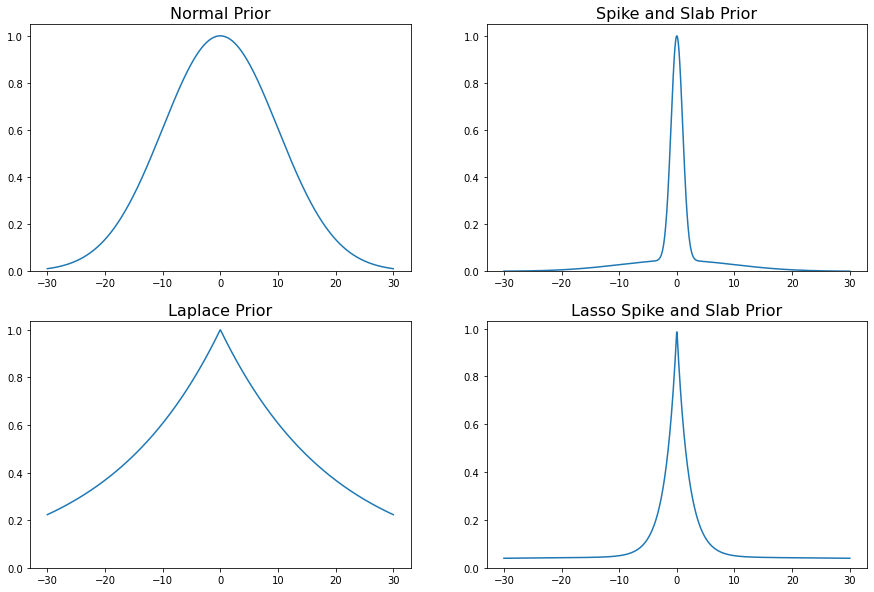

In [88]:
xgrid = np.linspace(-30, 30, 1000)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 4))

axes[0][0].plot(xgrid, np.exp(-0.5*(xgrid**2)/100)) # tau = 10
axes[0][0].set_title("Normal Prior", fontsize=16)

axes[1][0].plot(xgrid, np.exp(-0.5*np.abs(xgrid)/10)) # tau = 10
axes[1][0].set_title("Laplace Prior", fontsize=16)

c_ss = 10
intersect = 10
tau_ss = intersect / np.sqrt(2 * np.log(c_ss) * c_ss**2/(c_ss**2 - 1))

axes[0][1].plot(xgrid, (1-tau_ss/100)*np.exp(-0.5*(xgrid**2))+(tau_ss/100)*np.exp(-0.5*(xgrid**2)/(c_ss**2)))
axes[0][1].set_title("Spike and Slab Prior", fontsize=16)

axes[1][1].plot(xgrid, (1-tau_ss/100)*np.exp(-0.5*np.abs(xgrid))+(tau_ss/100)*np.exp(-0.5*np.abs(xgrid)/(c_ss**2)))
axes[1][1].set_title("Lasso Spike and Slab Prior", fontsize=16)

#sns.kdeplot(cmdstanpy_horseshoe_data1['numeric'], ax=axes[0][2], label="tau=1")
#sns.kdeplot(cmdstanpy_horseshoe_data10['numeric'], ax=axes[0][2], label="tau=10")
#axes[0][2].legend(fontsize=12)
#axes[0][2].set_title("Horseshoe", fontsize=16)

#sns.kdeplot(cmdstanpy_finnish_horseshoe_data100, ax=axes[1][2], label="tau=100")
#sns.kdeplot(cmdstanpy_finnish_horseshoe_data01, ax=axes[1][2], label="tau=0.1")
#axes[1][2].legend(fontsize=12)
#axes[1][2].set_title("Finnish Horseshoe", fontsize=16)


for i in range(2):
    for j in range(2):
        axes[i, j].set_ylim(0)
    
plt.show()

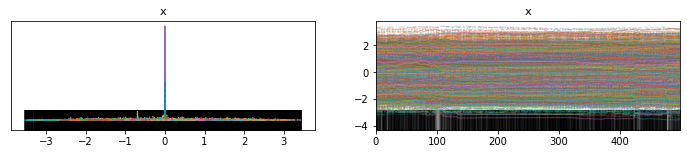

In [106]:
az.plot_trace(cmdstanpy_horseshoe_data1, var_names=["x"])
plt.show()

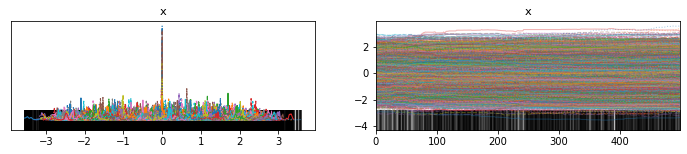

In [90]:
az.plot_trace(cmdstanpy_horseshoe_data10, var_names=["x"])
plt.show()

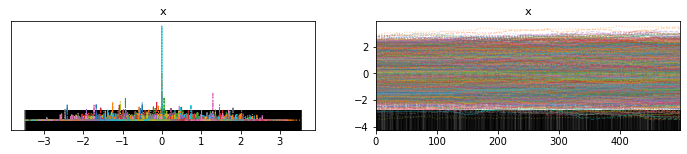

In [97]:
az.plot_trace(cmdstanpy_finnish_horseshoe_data10, var_names=["x"])
plt.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn(

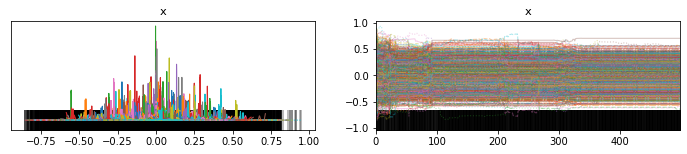

In [100]:
az.plot_trace(cmdstanpy_finnish_horseshoe_data1, var_names=["x"])
plt.show()

In [102]:
[np.sum(cmdstanpy_horseshoe_data1.sample_stats.diverging),
np.sum(cmdstanpy_horseshoe_data10.sample_stats.diverging),
np.sum(cmdstanpy_finnish_horseshoe_data10.sample_stats.diverging),
np.sum(cmdstanpy_finnish_horseshoe_data1.sample_stats.diverging)]

[<xarray.DataArray 'diverging' ()>
 array(1448),
 <xarray.DataArray 'diverging' ()>
 array(1026),
 <xarray.DataArray 'diverging' ()>
 array(1315),
 <xarray.DataArray 'diverging' ()>
 array(1869)]

SyntaxError: invalid syntax (94665445.py, line 5)

## Unit balls plot


Normal prior: $- \log \pi(\beta) = \|\beta\|_2^2 / \tau$

DE prior:  $- \log \pi(\beta) = \|\beta\|_1 / \tau$


Horseshoe prior: $- \log \pi(\beta_1, \beta_2) \approx \log \log \left(1 + \frac{2 \tau^2}{\beta_1^2} \right) +  \log \log \left(1 + \frac{2 \tau^2}{\beta_2^2} \right)$

In [172]:
from scipy.optimize import fsolve

def loglog(v):
    return np.log(np.log(v))

def neg_log_hors(beta1, beta2, r, tau):
    return -loglog(1 + 2 * tau**2 / beta1**2) + loglog(1 + 2 * tau**2 / beta2**2)

def get_hors_levelset(beta1, r=1, tau=1):
    # Given Beta1, find Beta2 that complies to make the points
    def to_solve(beta2):
        return 1 - neg_log_hors(beta1, beta2, r, tau)
    point2 = fsolve(to_solve, 0.2)
    # Return a vector for all points beta1,point2 that comply
    return point2

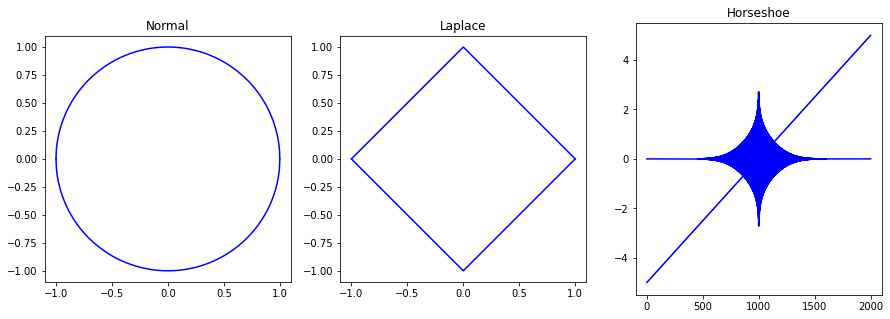

In [177]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

r = 1
tau = 1

x = np.linspace(-1, 1, 1000)
axes[0].plot(x, np.sqrt(1 - x**2), color='blue')
axes[0].plot(x, -np.sqrt(1 - x**2), color='blue')
axes[0].set_title("Normal")
axes[0].plot(x, np.sqrt(1 - x**2), color='blue')
axes[0].plot(x, -np.sqrt(1 - x**2), color='blue')

axes[1].set_title("Laplace")
axes[1].plot(x, 1-np.abs(x),color='blue')
axes[1].plot(x, -1+np.abs(x),color='blue')
axes[1].set_title("Laplace")

x = np.linspace(-5, 5, 1000)
points = []
for point1 in x:
    sol = get_hors_levelset(point1, r, tau)
    if sol.size != 0:
        for point2 in sol:
            points.append([point1, point2])
            points.append([point1, -point2])
axes[2].plot(points,color='blue')
axes[2].set_title("Horseshoe")
# axes[2].fill(x, get_hors_levelset(x), edgecolor='r', fill=False)

for i in range(2):
    axes[i].set_aspect('equal', 'box')
    
plt.show()

# Exercise 2 

In [11]:
import os
os.environ['CMDSTAN'] = '/Users/Cheesecake/.cmdstanr/cmdstan-2.28.1'
from cmdstanpy import CmdStanModel, set_cmdstan_path
import arviz as az

#### Hint 1

To implement the spike-and-slab priors in Stan, you need to marginalize out the latent parameter $p_j$ and write
$$
    \beta_j \sim \pi(\beta_j)
$$
$\pi(\beta_j)$ will be a mixture of two densities, say $\pi(\beta_j) = w \pi_1(\beta_j + (1-w) \pi_2(\beta_j)$.

In stan, you cannot write


   beta_j $\sim  w \pi_1(\beta_j + (1-w) \pi_2(\beta_j)$


But what you can do instead is writing

<pre>
target_lpdf += log_mix(w,
        p1_lpdf(beta | params1),
        p2_lpdf(beta | params2));
</pre>    
        
Where p1_lpdf is the log-probability density function associated to $\pi_1$, i.e. if $\pi_1 = \mathcal{N}(0, 10^2)$ and $\pi_2 = \mathcal{N}(0, 0.1^2)$ we write

<pre>
target_lpdf += log_mix(w, 
       normal_lpdf(beta | 0, 10),
       normal_lpdf(beta | 0, 0.1));
</pre>


#### Hint 2

If you get way too many divergent transistions, it might be due to the heavy tails of the Cauchy distribution.
A practical way to get rid of them is to assume instead an half-T prior (i.e., a student's T distribution truncated on $[0, +\infty)$ with small degrees of freedom parameters.

### Select data and discard missing values

In [12]:
Y.columns

Index(['APV', 'ATV', 'IDV', 'LPV', 'NFV', 'RTV', 'SQV'], dtype='object')

In [13]:
X_df = X.copy()

In [14]:
Y_df = Y.copy()

In [15]:
y = Y["APV"].values
keep = np.where(~np.isnan(y))
y = y[keep]
X = X.values[keep, :][0, :, :]

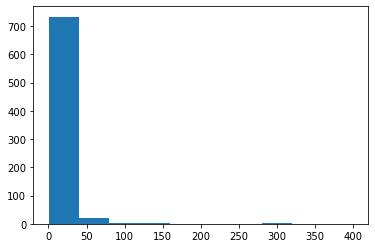

In [16]:
plt.hist(y)
plt.show()

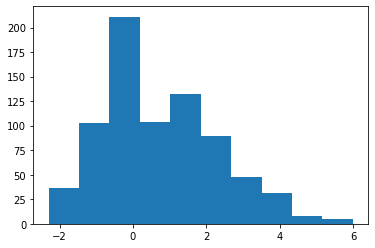

In [17]:
plt.hist(np.log(y))
plt.show()

In [18]:
y = np.log(y)

In [19]:
normal_reg = """
    data {
        int<lower=0> p;
        int<lower=0> n;
        matrix[n, p] X;
        vector[n] y;
    }
    
    parameters {
        real<lower=0> tau;
        real alpha;
        vector[p] beta;
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[n] mean = X * beta + alpha;
    }
    
    model {
        tau ~ cauchy(0, 1);
        sigma ~ lognormal(0, 3);
        beta ~ normal(0, tau);   
        alpha ~ normal(9, 2);
        for (i in 1:n){
            y[i] ~ normal(mean[i], sigma);
        }
    }
"""

stan_file = "./normal.stan"

with open(stan_file, "w") as f:
    print(normal_reg, file=f)

normal_reg = CmdStanModel(stan_file=stan_file)

INFO:cmdstanpy:compiling stan program, exe file: /media/kanthavel/data/code/Bayesian_Statistics/Project/BAY-STATS-Project-ABDPPS/Interactive/normal
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /media/kanthavel/data/code/Bayesian_Statistics/Project/BAY-STATS-Project-ABDPPS/Interactive/normal


In [20]:
%%time
reg_data = {
    "n": len(y),
    "p": X.shape[1],
    "y": y,
    "X": X        
}

fit = normal_reg.sample(reg_data)
normal_az = az.from_cmdstanpy(fit)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2


CPU times: user 1.12 s, sys: 39.7 ms, total: 1.16 s
Wall time: 16.3 s


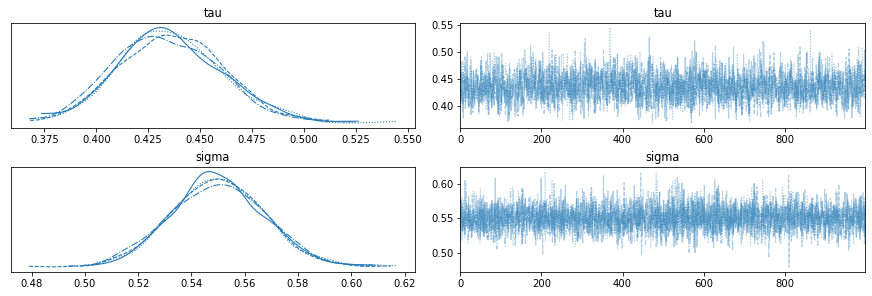

In [21]:
az.plot_trace(normal_az, var_names=["tau", "sigma"])
plt.show()

In [22]:
laplace_reg = """
    data {
        int<lower=0> p;
        int<lower=0> n;
        matrix[n, p] X;
        vector[n] y;
    }
    
    parameters {
        real<lower=0> tau;
        real alpha;
        vector[p] beta;
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[n] mean = X * beta + alpha;
    }
    
    model {
        tau ~ cauchy(0, 1);
        sigma ~ lognormal(0, 3);
        beta ~ double_exponential(0, tau);
        alpha ~ normal(9, 2);
        y ~ normal(mean, sigma);
    }
"""

stan_file = "./laplace.stan"

with open(stan_file, "w") as f:
    print(laplace_reg, file=f)

laplace_reg = CmdStanModel(stan_file=stan_file)

INFO:cmdstanpy:compiling stan program, exe file: /media/kanthavel/data/code/Bayesian_Statistics/Project/BAY-STATS-Project-ABDPPS/Interactive/laplace
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /media/kanthavel/data/code/Bayesian_Statistics/Project/BAY-STATS-Project-ABDPPS/Interactive/laplace


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4


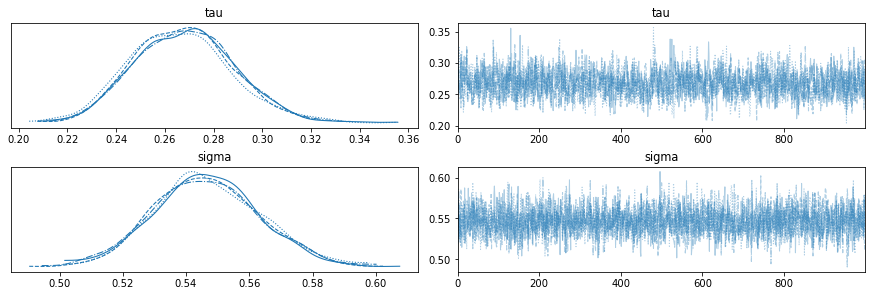

CPU times: user 1.49 s, sys: 54.7 ms, total: 1.54 s
Wall time: 46.5 s


In [23]:
%%time
fit = laplace_reg.sample(reg_data)
laplace_az = az.from_cmdstanpy(fit)
az.plot_trace(laplace_az, var_names=["tau", "sigma"])
plt.show()

In [38]:
spike_slab_code = """
    data {
        int<lower=0> p;
        int<lower=0> n;
        matrix[n, p] X;
        vector[n] y;
    }
    
    parameters {
        real alpha;
        vector[p] beta;
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[n] mean = X * beta + alpha;
    }
    
    model {
        sigma ~ lognormal(0, 3);
        alpha ~ normal(9, 2);
        target += log_mix(0.5, 
                normal_lpdf(beta | 0, 0.1), 
                normal_lpdf(beta | 0, 10));
        //for (i in 1:p) {
          //  target += log_mix(0.5, 
            //    normal_lpdf(beta[i] | 0, 0.1), 
              //  normal_lpdf(beta[i] | 0, 10));
       // }
        y ~ normal(mean, sigma);
    }
"""

stan_file = "./spike_slab.stan"

with open(stan_file, "w") as f:
    print(spike_slab_code, file=f)

spike_slab = CmdStanModel(stan_file=stan_file)

INFO:cmdstanpy:compiling stan program, exe file: /media/kanthavel/data/code/Bayesian_Statistics/Project/BAY-STATS-Project-ABDPPS/Interactive/spike_slab
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /media/kanthavel/data/code/Bayesian_Statistics/Project/BAY-STATS-Project-ABDPPS/Interactive/spike_slab


In [39]:
%%time
fit = spike_slab.sample(reg_data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2


KeyboardInterrupt: 

In [40]:
ss_az = az.from_cmdstanpy(fit)
az.plot_trace(ss_az, var_names=["sigma"])
plt.show()

NameError: name 'ss_az' is not defined

In [36]:
spike_slab_lasso_code = """
    data {
        int<lower=0> p;
        int<lower=0> n;
        matrix[n, p] X;
        vector[n] y;
    }
    
    parameters {
        real alpha;
        vector[p] beta;
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[n] mean = X * beta + alpha;
    }
    
    model {
        sigma ~ lognormal(0, 3);
        alpha ~ normal(9, 2);
        target += log_mix(0.5, 
                double_exponential_lpdf(beta | 0, 0.1), 
                double_exponential_lpdf(beta | 0, 10));
        //for (i in 1:p) {
          //  target += log_mix(0.5, 
            //    double_exponential_lpdf(beta[i] | 0, 0.1), 
              //  double_exponential_lpdf(beta[i] | 0, 10));
        //}
        y ~ normal(mean, sigma);
    }
"""

stan_file = "./spike_slab_lasso.stan"

with open(stan_file, "w") as f:
    print(spike_slab_lasso_code, file=f)

spike_slab_lasso = CmdStanModel(stan_file=stan_file)

INFO:cmdstanpy:compiling stan program, exe file: /media/kanthavel/data/code/Bayesian_Statistics/Project/BAY-STATS-Project-ABDPPS/Interactive/spike_slab_lasso
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /media/kanthavel/data/code/Bayesian_Statistics/Project/BAY-STATS-Project-ABDPPS/Interactive/spike_slab_lasso


In [41]:
%%time
fit = spike_slab_lasso.sample(reg_data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


KeyboardInterrupt: 

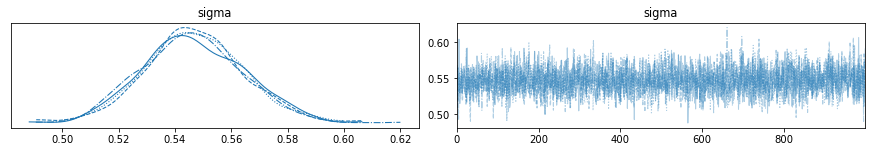

In [42]:
ssl_az = az.from_cmdstanpy(fit)
az.plot_trace(ssl_az, var_names=["sigma"])
plt.show()

In [50]:
reg_hors_code = """
    data {
        int<lower=0> p;
        int<lower=0> n;
        matrix[n, p] X;
        matrix[n, 1] y;
    }
    
    parameters {
        real<lower=0> tau;
        real alpha;
        vector[p] beta;
        real sigma;
        vector<lower=0>[p] lambda;
    }
    
    transformed parameters {
        vector[n] mean = X * beta + alpha;
    }
    
    model {
        tau ~ cauchy(0, 1);
        sigma ~ lognormal(0, 3);
        alpha ~ normal(9, 2);
        lambda ~ cauchy(0, 1);
        beta ~ normal(0, tau * lambda);
        y ~ normal(mean, sigma);
    }
"""

stan_file = "./reg_hors.stan"

with open(stan_file, "w") as f:
    print(reg_hors_code, file=f)

horseshoe = CmdStanModel(stan_file=stan_file)

INFO:cmdstanpy:compiling stan program, exe file: /media/kanthavel/data/code/Bayesian_Statistics/Project/BAY-STATS-Project-ABDPPS/Interactive/reg_hors
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
ERROR:cmdstanpy:file /media/kanthavel/data/code/Bayesian_Statistics/Project/BAY-STATS-Project-ABDPPS/Interactive/reg_hors.stan, exception ERROR
Semantic error in '/media/kanthavel/data/code/Bayesian_Statistics/Project/BAY-STATS-Project-ABDPPS/Interactive/reg_hors.stan', line 27, column 8 to column 32:
   -------------------------------------------------
    25:          lambda ~ cauchy(0, 1);
    26:          beta ~ normal(0, tau * lambda);
    27:          y ~ normal(mean, sigma);
                 ^
    28:      }
    29:  
   -------------------------------------------------

Ill-typed arguments to '~' statement. No distribution 'normal' was found with the correct signature.
make: *** [make/program:50: /media/kanthavel/data/code/Bayesian_Statistics/Project/BAY-STATS-P

ValueError: Unable to compile Stan model file: /media/kanthavel/data/code/Bayesian_Statistics/Project/BAY-STATS-Project-ABDPPS/Interactive/reg_hors.stan.

In [ ]:
%%time
fit = horseshoe.sample(reg_data)
horse_az = az.from_cmdstanpy(fit)
az.plot_trace(horse_az, var_names=["sigma"])
plt.show()

In [ ]:
az.plot_trace(horse_az, var_names=["sigma", "tau", "c"])
plt.tight_layout()
plt.show()

In [51]:
reg_finn_code = """
    data {
        int<lower=0> p;
        int<lower=0> n;
        matrix[n, p] X;
        vector[n] y;
    }
    
    parameters {
        real<lower=0> tau;
        real alpha;
        vector[p] beta;
        real sigma;
        vector<lower=0>[p] lambda;
        vector<lower=0>[p] lambda_t2;

    }
    
    transformed parameters {
        vector[n] mean = X * beta + alpha;
    }
    
    model {
    c ~ inv_gamma(1.5, 1.5);
        tau ~ cauchy(0, 1);
        sigma ~ lognormal(0, 3);
        alpha ~ normal(9, 2);
        for (i in 1:p) {
            lambda[i] ~ cauchy(0, 1);
            lambda_t2[i] = (square(c*lambda[i]))/(square(c) + square(tau*lambda[i]));
            beta[i] = normal(0, square(tau*lambda[i]));
    }
        y ~ normal(mean, sigma);
    }
"""

stan_file = "./reg_finn.stan"

with open(stan_file, "w") as f:
    print(reg_finn_code, file=f)

finn_horseshoe = CmdStanModel(stan_file=stan_file)

INFO:cmdstanpy:compiling stan program, exe file: /media/kanthavel/data/code/Bayesian_Statistics/Project/BAY-STATS-Project-ABDPPS/Interactive/reg_finn
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
ERROR:cmdstanpy:file /media/kanthavel/data/code/Bayesian_Statistics/Project/BAY-STATS-Project-ABDPPS/Interactive/reg_finn.stan, exception ERROR
Syntax error in '/media/kanthavel/data/code/Bayesian_Statistics/Project/BAY-STATS-Project-ABDPPS/Interactive/reg_finn.stan', line 31, column 12 to column 16, parsing error:
   -------------------------------------------------
    29:              lambda[i] ~ cauchy(0, 1);
    30:              lambda_t2[i] = (square(c*lambda[i]))/(square(c) + square(tau*lambda[i]))
    31:              beta[i] = normal(0, square(tau*lambda[i]));
                     ^
    32:      }
    33:          y ~ normal(mean, sigma);
   -------------------------------------------------

Found a expression where we expected a statement. Is there a missing s

ValueError: Unable to compile Stan model file: /media/kanthavel/data/code/Bayesian_Statistics/Project/BAY-STATS-Project-ABDPPS/Interactive/reg_finn.stan.

In [52]:
%%time
fit = finn_horseshoe.sample(reg_data)
finn_horseshoe_az = az.from_cmdstanpy(fit)
az.plot_trace(finn_horseshoe_az, var_names=["sigma"])
plt.show()

NameError: name 'finn_horseshoe' is not defined

In [ ]:
az.plot_trace(finn_horseshoe_az, var_names=["sigma", "tau", "c"])
plt.tight_layout()
plt.show()

In [57]:
all_models = {
    "normal": normal_az,
    "laplace": laplace_az,
#     "ss": ss_az,
#     "ssl": ssl_az,
#     "reg_hors": horse_az,
#     "reg_finn_hors": finn_horseshoe_az
}
az.compare(all_models, var_name="log_lik")

TypeError: compare() got an unexpected keyword argument 'var_name'

# Exercise 3: Variable Selection

In [58]:
for model_name, model_result in all_models.items():
    print(f'Checking model {model_name}')
    beta_confidence_intervals = az.hdi(model_result, hdi_prob=0.95).beta
    keep_betas = np.logical_and(beta_confidence_intervals[:,0] < 0, 0 < beta_confidence_intervals[:,1])
    keep_betas_index = np.where(keep_betas)[0]
    print(f'Variables selected using {model_name} are: \n')
    print(', '.join(X_df.columns[keep_betas]))

Checking model normal
Variables selected using normal are: 

P4.A, P13.A, P20.A, P22.A, P28.A, P37.A, P51.A, P54.A, P63.A, P71.A, P73.A, P74.A, P79.A, P91.A, P37.C, P63.C, P67.C, P73.C, P82.C, P91.C, P95.C, P4.D, P12.D, P25.D, P34.D, P35.D, P37.D, P60.D, P61.D, P63.D, P65.D, P68.D, P69.D, P79.D, P88.D, P98.D, P7.E, P12.E, P16.E, P17.E, P18.E, P20.E, P21.E, P34.E, P35.E, P37.E, P47.E, P60.E, P61.E, P63.E, P65.E, P67.E, P68.E, P70.E, P72.E, P92.E, P19.F, P23.F, P24.F, P38.F, P59.F, P63.F, P66.F, P67.F, P95.F, P8.G, P16.G, P21.G, P35.G, P37.G, P52.G, P57.G, P61.G, P67.G, P77.G, P88.G, P7.H, P10.H, P18.H, P37.H, P61.H, P63.H, P69.H, P79.H, P92.H, P3.I, P11.I, P12.I, P13.I, P14.I, P15.I, P18.I, P19.I, P20.I, P23.I, P33.I, P36.I, P37.I, P38.I, P41.I, P53.I, P62.I, P66.I, P71.I, P72.I, P75.I, P77.I, P85.I, P89.I, P93.I, P12.K, P14.K, P20.K, P34.K, P41.K, P43.K, P45.K, P55.K, P57.K, P61.K, P69.K, P70.K, P72.K, P74.K, P85.K, P92.K, P6.L, P11.L, P13.L, P15.L, P18.L, P19.L, P20.L, P23.L, P33.L, P

In [105]:
stan_code =  """
    data {
        int<lower=0> p;
        int<lower=0> n;
        matrix[n, p] X;
        vector[n] Y;
    }
    
    parameters {
        real<lower=0> tau;
        real alpha;
        vector[p] beta;
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[n] mean = X * beta + alpha;
    }
    
    model {
        tau ~ cauchy(0, 1);
        sigma ~ lognormal(0, 3);
        beta ~ normal(0, tau);   
        alpha ~ normal(9, 2);
        for (i in 1:n){
            Y[i] ~ normal(mean[i], sigma);
        }
    }
"""

stan_file = "./spike_slab_hier.stan"

with open(stan_file, "w") as f:
    print(stan_code, file=f)

prior_stan_model = CmdStanModel(stan_file=stan_file)

INFO:cmdstanpy:compiling stan program, exe file: /media/kanthavel/data/code/Bayesian_Statistics/Project/BAY-STATS-Project-ABDPPS/Interactive/spike_slab_hier
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /media/kanthavel/data/code/Bayesian_Statistics/Project/BAY-STATS-Project-ABDPPS/Interactive/spike_slab_hier


In [106]:
y.shape

(767,)

In [107]:
X.shape

(767, 361)

In [55]:
%%time
normal_data = {
    "p": X.shape[1],
    "n": X.shape[0],
    "X": X,
    "Y": y
}

stan_fit = prior_stan_model.sample(data=normal_data, chains=4, parallel_chains=4, 
                                 iter_warmup=1000, iter_sampling=5000)

cmdstanpy_data = az.from_cmdstanpy(stan_fit)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4


CPU times: user 2.13 s, sys: 58.7 ms, total: 2.19 s
Wall time: 23.2 s


In [68]:
beta_confidence_intervals = az.hdi(cmdstanpy_data, hdi_prob=0.95).beta
keep_betas = np.logical_and(beta_confidence_intervals[:,0] < 0, 0 < beta_confidence_intervals[:,1])
keep_betas_index = np.where(keep_betas)[0]

In [69]:
keep_betas

<xarray.DataArray 'beta' (beta_dim_0: 361)>
array([ True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True, False,  True,  True, False,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
...
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False,  True,  True, False,  True,  True,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 0 1 2 3 4 5 6 ... 354 355 356 357 358 359 360

In [73]:
keep_betas.shape, keep_betas_index.shape

((361,), (322,))

In [71]:
keep_betas_index

array([  0,   2,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  17,  18,  19,  20,  21,  22,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  64,  65,  66,  68,  69,  70,  71,  72,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 108, 109, 110, 111, 112, 114, 115, 117,
       118, 119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145,
       146, 147, 148, 149, 150, 151, 153, 154, 157, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
       176, 177, 178, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 20

In [110]:
print(', '.join(X_df.columns[keep_betas]))

P4.A, P13.A, P20.A, P22.A, P28.A, P37.A, P51.A, P54.A, P63.A, P71.A, P73.A, P74.A, P79.A, P82.A, P91.A, P37.C, P63.C, P67.C, P73.C, P82.C, P91.C, P95.C, P4.D, P12.D, P25.D, P34.D, P35.D, P37.D, P60.D, P61.D, P63.D, P65.D, P68.D, P69.D, P79.D, P88.D, P98.D, P7.E, P12.E, P16.E, P17.E, P18.E, P20.E, P21.E, P34.E, P35.E, P37.E, P47.E, P60.E, P61.E, P63.E, P65.E, P67.E, P68.E, P70.E, P72.E, P92.E, P19.F, P23.F, P24.F, P38.F, P59.F, P63.F, P66.F, P67.F, P95.F, P8.G, P16.G, P21.G, P35.G, P37.G, P52.G, P57.G, P61.G, P67.G, P77.G, P88.G, P7.H, P10.H, P18.H, P37.H, P61.H, P63.H, P69.H, P79.H, P92.H, P3.I, P11.I, P12.I, P13.I, P14.I, P15.I, P18.I, P19.I, P20.I, P23.I, P33.I, P36.I, P37.I, P38.I, P41.I, P53.I, P62.I, P66.I, P71.I, P72.I, P75.I, P77.I, P85.I, P89.I, P93.I, P12.K, P14.K, P20.K, P34.K, P41.K, P43.K, P45.K, P55.K, P57.K, P61.K, P69.K, P70.K, P72.K, P74.K, P85.K, P92.K, P6.L, P11.L, P13.L, P15.L, P18.L, P19.L, P20.L, P23.L, P33.L, P38.L, P45.L, P53.L, P63.L, P64.L, P66.L, P67.L, P71.L,

# Exercise 4: take me to the hierarchy-land

In [ ]:
spike_slab_hier_code = """
"""

stan_file = "./spike_slab_hier.stan"

with open(stan_file, "w") as f:
    print(spike_slab_hier_code, file=f)

spike_slab_hier = CmdStanModel(stan_file=stan_file)

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

In [ ]:
reg_data = {
    "n": len(y),
    "p": X.shape[1],
    "k": y.shape[1],
    "y": y,
    "X": X        
}

spike_slab_fit = spike_slab_hier.sample(data=reg_data, chains=4, parallel_chains=4, 
                iter_warmup=1000, iter_sampling=1000, adapt_delta=0.9)

spike_slab_fit_data = az.from_cmdstanpy(spike_slab_fit)

In [ ]:
az.plot_trace(spike_slab_fit_data, var_names="beta", compact=True)
plt.tight_layout()
plt.show()

In [ ]:
az.plot_forest(spike_slab_fit_data, var_names="beta")

In [ ]:
az.plot_trace(spike_slab_fit_data, var_names="p0s", compact=False)
plt.tight_layout()
plt.show()

### Hierarchical Regularised Horseshoe